#  Librerias y Modelo

In [ ]:
import os
import numpy as np
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import zipfile
import random
from google.colab import drive

In [ ]:
# Habilitar google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

def Weighted_Cross_Entropy(beta):
    def convert_to_logits(y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        return tf.math.log(y_pred / (1 - y_pred))

    def loss(y_true, y_pred):
        y_pred = convert_to_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, labels=y_true, pos_weight=beta)
        return tf.reduce_mean(loss)

    return loss


class RepeatChannels(Layer):
    def __init__(self, rep, **kwargs):
        super().__init__(**kwargs)
        self.rep = rep

    def call(self, inputs):
        return tf.tile(inputs, [1, 1, 1, self.rep])

In [ ]:
# Cargar modelo y visualizar
from tensorflow.keras.models import load_model
# modelo4 = load_model('/content/modelo4.h5')
modelo = load_model('/content/modelo3_b2.h5', custom_objects={'RepeatChannels': RepeatChannels, 'loss': Weighted_Cross_Entropy(10.0)})
#modelo2 = load_model('/content/clasificador_superficie_SA.h5')

# Importar Imagen

In [ ]:
import cv2
import numpy as np

# Ruta a tu imagen normal
img_path = '/content/drive/MyDrive/TESIS/Datos/test/images/regular3.png'

# Leer en RGB
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Redimensionar si tu modelo lo necesita (ejemplo: 256x256)
img = cv2.resize(img, (512, 512))

# Normalizar a [0, 1]
# img = img / 255.0

# Asegúrate de que img tenga shape (224, 224, 3)
img_batch = np.expand_dims(img, axis=0)  # shape will be (1, 224, 224, 3)

# Expandir dimensiones: (256, 256, 3) -> (1, 256, 256, 3)
# img_input = np.expand_dims(img, axis=0)

imgtest = '/content/drive/MyDrive/TESIS/Datos/test/masks/irregular4.png'
# Leer en RGB
imgtest = cv2.imread(imgtest)
imgtest = cv2.cvtColor(imgtest, cv2.COLOR_BGR2RGB)


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


# Prediccion de mascara

In [ ]:
prediction = modelo.predict(img_batch)

umbral = 0.5  # puedes ajustar este valor
binary_mask = (prediction[0, :, :, 0] > umbral).astype('uint8')  # 1 para valores mayores a umbral, 0 si no

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


# PREDICCION

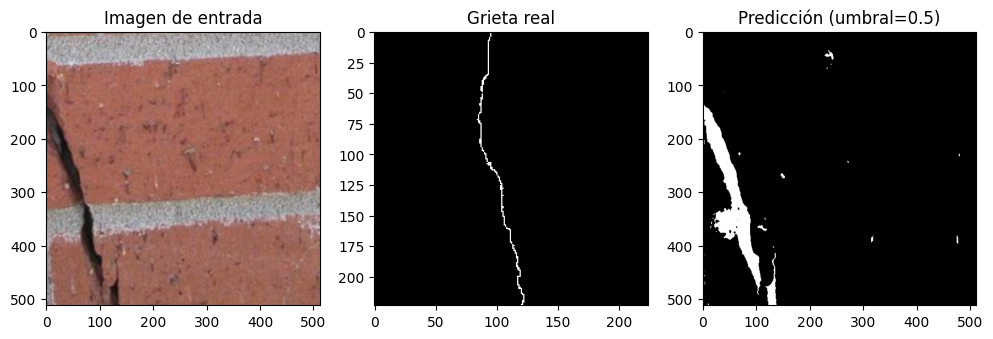

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Imagen de entrada")
plt.imshow(img)

plt.subplot(1, 3, 2)
plt.title("Grieta real")
plt.imshow(imgtest, cmap='gray')

plt.subplot(1, 3, 3)
plt.title(f"Predicción (umbral={umbral})")
plt.imshow(binary_mask, cmap='gray')

plt.show()

# Etiquetar componentes

In [ ]:
import cv2
import numpy as np


def get_orientation_and_linearity(cnt):
    data_pts = np.squeeze(cnt).astype(np.float32)
    if len(data_pts.shape) < 2:
        return None, None
    mean = np.mean(data_pts, axis=0)
    cov = np.cov(data_pts - mean, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    principal_vector = eigenvectors[:, np.argmax(eigenvalues)]
    angle_rad = np.arctan2(principal_vector[1], principal_vector[0])
    angle_deg = abs(np.degrees(angle_rad) % 180)

    # Verificar si sigue una línea (linealidad)
    projected = np.dot(data_pts - mean, principal_vector)
    reconstructed = np.outer(projected, principal_vector) + mean
    error = np.mean(np.linalg.norm(data_pts - reconstructed, axis=1))
    is_linear = error < 5  # umbral: ajustar si es necesario

    return angle_deg, is_linear

# Leer imagen binaria

color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    angle, is_linear = get_orientation_and_linearity(cnt)

    if angle is not None and is_linear:
        if (25 <= angle <= 80) or (115 <= angle <= 155):
            color = (0, 0, 255)  # Rojo - Diagonal
        elif 75 <= angle <= 105:
            color = (0, 255, 0)  # Verde - Vertical
        elif angle <= 15 or angle >= 165:
            color = (255, 102, 255)  # Púrpura claro - Horizontal
        else:
            color = (128, 128, 128)  # Gris - Escalonada
    else:
        color = (255, 0, 0)  # Gris por defecto (poca linealidad o puntos)

    cv2.drawContours(color_mask, [cnt], -1, color, -1)

cv2.imwrite('output_colored_mask.png', color_mask)


True

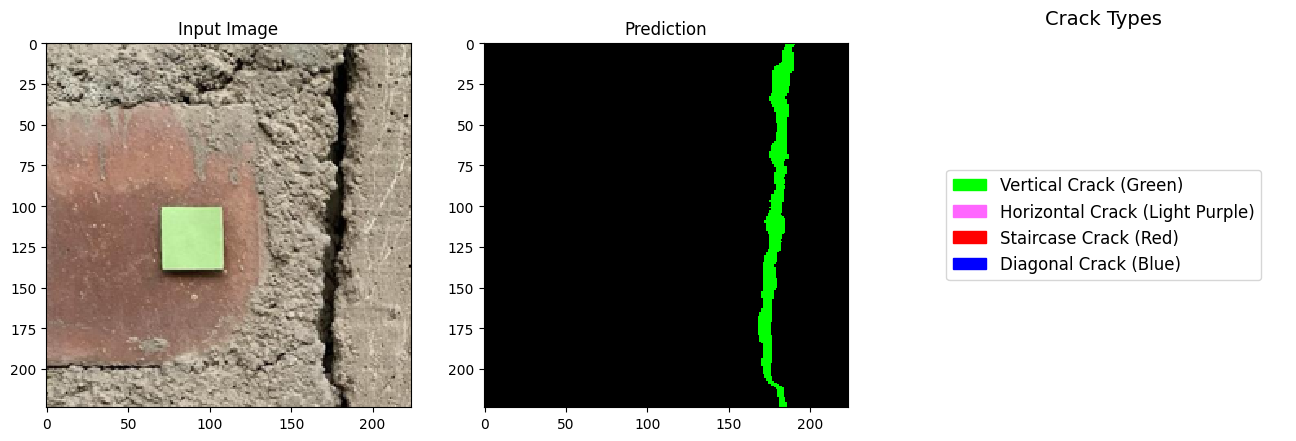

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(16, 5))

# Imagen original
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(img, interpolation='nearest')
plt.axis('on')  # muestra ejes y ticks para ver pixeles

# Imagen con colores, sin suavizado para ver pixeles
plt.subplot(1, 3, 2)
plt.title("Prediction")
plt.imshow(color_mask, interpolation='nearest')
plt.axis('on')

# Leyenda al costado sin imagen
plt.subplot(1, 3, 3)
plt.axis('off')

green_patch = mpatches.Patch(color=(0/255, 1, 0), label='Vertical Crack (Green)')
purple_patch = mpatches.Patch(color=(1, 102/255, 1), label='Horizontal Crack (Light Purple)')
gray_patch = mpatches.Patch(color=(1, 0, 0), label='Staircase Crack (Red)')
red_patch = mpatches.Patch(color=(0, 0, 1), label='Diagonal Crack (Blue)')  # Grieta diagonal

plt.legend(handles=[green_patch, purple_patch, gray_patch, red_patch], loc='center', fontsize=12)
plt.title("Crack Types", fontsize=14)

plt.show()


# Esqueletizacion

Ancho promedio estimado de la grieta: 7.27 píxeles


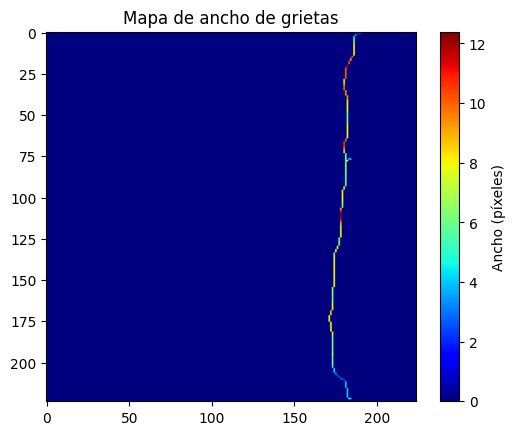

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops


# Asegurarse que los valores sean 0 y 1
binary = (binary_mask > 0).astype(np.uint8)

# Obtener el esqueleto de las grietas
skeleton = skeletonize(binary).astype(np.uint8)

# Distancia euclidiana al borde más cercano (mapa de distancias)
dist_transform = cv2.distanceTransform(binary, distanceType=cv2.DIST_L2, maskSize=5)

# Estimar ancho: en cada punto del esqueleto, multiplicamos por 2 la distancia al borde
crack_width_map = dist_transform * skeleton * 2  # Ancho en píxeles

# Promedio del ancho de todas las grietas
mean_width = crack_width_map[crack_width_map > 0].mean()
print(f"Ancho promedio estimado de la grieta: {mean_width:.2f} píxeles")

# Mostrar
plt.imshow(crack_width_map, cmap='jet')
plt.title('Mapa de ancho de grietas')
plt.colorbar(label='Ancho (píxeles)')
plt.show()

Cuadrado verde detectado


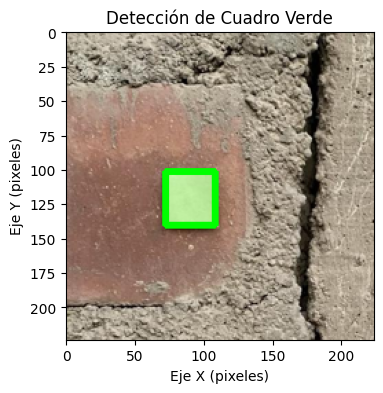

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen original
# img = cv2.imread('/path/to/tu_imagen.jpg')

# Copia para procesar
img_for_processing = img.copy()

# Convertir a HSV para detección de color
hsv = cv2.cvtColor(img_for_processing, cv2.COLOR_BGR2HSV)

# Rango de color verde fluorescente
lower_green = np.array([35, 40, 40])
upper_green = np.array([85, 255, 255])

# Máscara
mask = cv2.inRange(hsv, lower_green, upper_green)

# Encontrar contornos
contornos, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujar sobre imagen original si se detecta un cuadrado
if contornos:
    contorno_mayor = max(contornos, key=cv2.contourArea)
    epsilon = 0.02 * cv2.arcLength(contorno_mayor, True)
    approx = cv2.approxPolyDP(contorno_mayor, epsilon, True)

    if len(approx) == 4:
        x, y, w, h = cv2.boundingRect(approx)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)
        print("Cuadrado verde detectado")
    else:
        print("No se detectó un cuadrado")
else:
    print("No se detectó ningún contorno")

# Convertir BGR a RGB para mostrar con matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Mostrar con título y ejes
plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.title("Detección de Cuadro Verde")
plt.xlabel("Eje X (pixeles)")
plt.ylabel("Eje Y (pixeles)")
plt.grid(False)
plt.show()


In [ ]:
# Suponiendo que el cuadrado real mide 20 mm x 20 mm
lado_real_mm = 20  # milímetros

# Tamaño detectado en píxeles
pixeles_por_mm_ancho = w / lado_real_mm
pixeles_por_mm_alto = h / lado_real_mm

# Promedio para un solo valor
pixeles_por_mm = (pixeles_por_mm_ancho + pixeles_por_mm_alto) / 2

max_width = crack_width_map[crack_width_map > 0].max()

# ANCHO MAXIMO MM
anchoFin =  max_width / pixeles_por_mm
anchoFin

np.float32(6.6100264)

In [ ]:

from scipy.ndimage import distance_transform_edt

distance = distance_transform_edt(binary)  # Mide la distancia al fondo
ancho_local = skeleton * distance * 2  # Multiplicas por 2 porque la distancia es desde el centro al borde

anchos = ancho_local[skeleton > 0]
ancho_maximo = anchos.max()

ancho_maximo


AnchoMaximo = ancho_maximo/escala_px_mm
print(f" Ancho Máximo de la grieta: {AnchoMaximo} mm")

 Ancho Máximo de la grieta: 29.672012342918144 mm


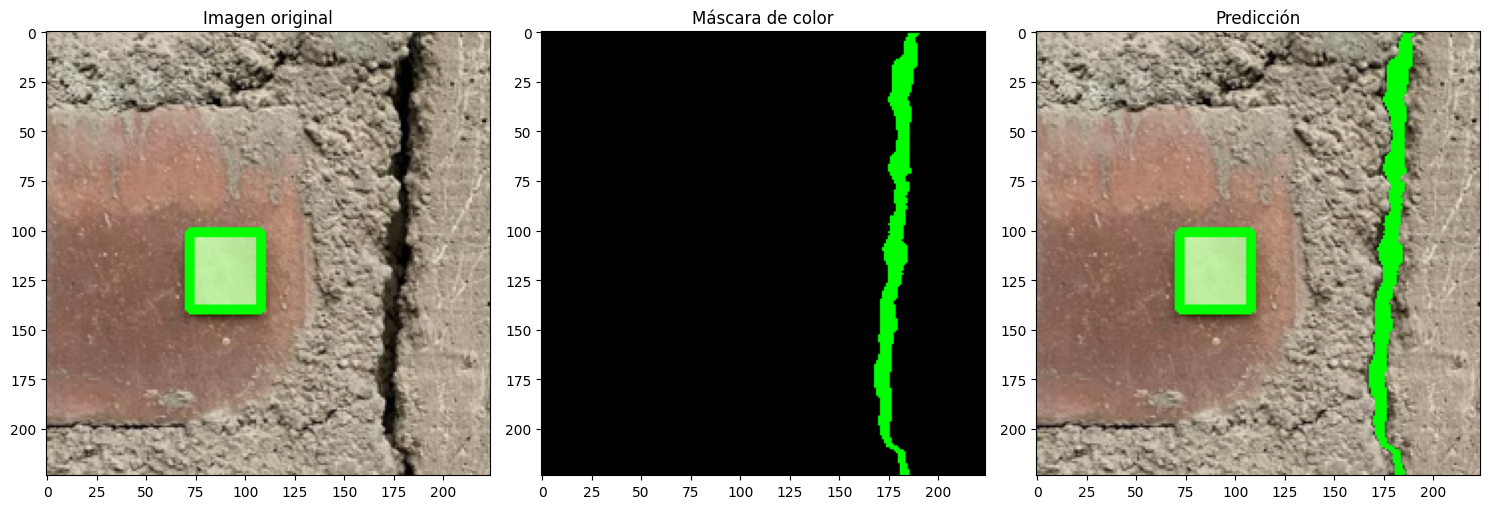

In [ ]:
# Crear máscara binaria (True donde color_mask tiene valores distintos de negro)
mask = np.any(color_mask != [0, 0, 0], axis=-1)

# Superponer color_mask sobre img
overlay = img.copy()
overlay[mask] = color_mask[mask]

# Convertir imágenes a RGB para visualización
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
color_mask_rgb = cv2.cvtColor(color_mask, cv2.COLOR_BGR2RGB)


# Mostrar las tres imágenes
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Imagen original')

plt.subplot(1, 3, 2)
plt.imshow(color_mask_rgb)
plt.title('Máscara de color')

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title('Predicción')


plt.tight_layout()
plt.show()

#PARA PAGINA WEB

In [ ]:
import cv2
import numpy as np
from google.colab import files
from PIL import Image
import io

# Subir imagen RGB
uploaded = files.upload()
image_file = list(uploaded.keys())[0]

# Leer imagen con PIL y convertir a OpenCV (RGB)
img = Image.open(io.BytesIO(uploaded[image_file])).convert('RGB')
img = np.array(img)

# Redimensionar si es necesario
img = cv2.resize(img, (512, 512))

# Expandir dimensiones para modelo
img_batch = np.expand_dims(img, axis=0)  # (1, 512, 512, 3)


Saving t7.png to t7.png


In [ ]:
prediction = modelo.predict(img_batch)

umbral = 0.5  # puedes ajustar este valor
binary_mask = (prediction[0, :, :, 0] > umbral).astype('uint8')  # 1 para valores mayores a umbral, 0 si no

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [ ]:
import time

# Medir tiempo de inferencia
start = time.time()
prediction = modelo.predict(img_batch)
end = time.time()

# Umbral y binarización
umbral = 0.5
binary_mask = (prediction[0, :, :, 0] > umbral).astype('uint8')

# Mostrar tiempo de inferencia
tiempo_inferencia = end - start
print(f"⏱️ Tiempo de inferencia: {tiempo_inferencia:.4f} segundos")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
⏱️ Tiempo de inferencia: 0.0780 segundos


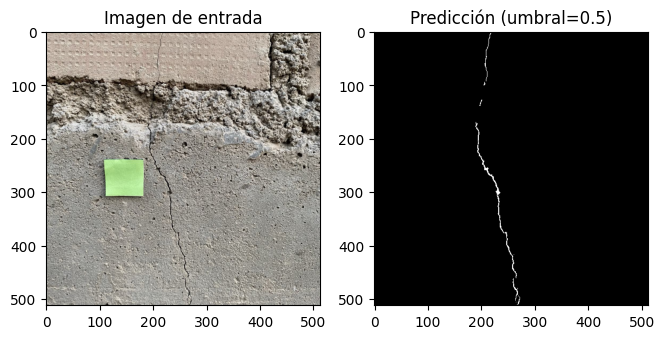

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title("Imagen de entrada")
plt.imshow(img)

plt.subplot(1, 3, 2)
plt.title(f"Predicción (umbral={umbral})")
plt.imshow(binary_mask, cmap='gray')

plt.show()

Ancho promedio estimado de la grieta: 2.39 píxeles
Ancho máximo estimado: 6.00 píxeles en (np.int64(468), np.int64(247))


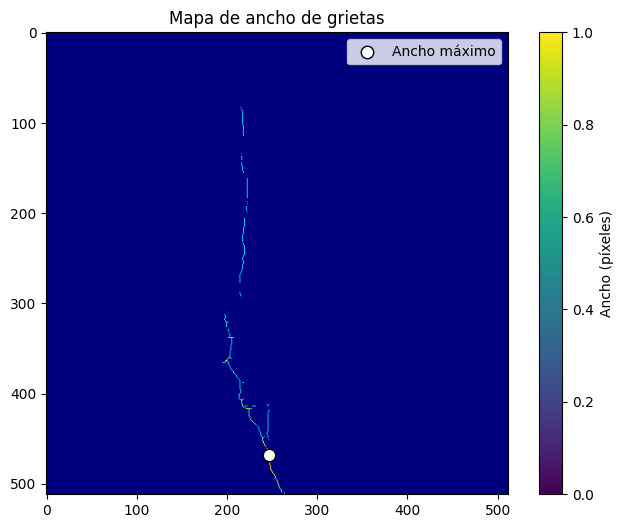

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.measure import label, regionprops

# Asegurarse que los valores sean 0 y 1
binary = (binary_mask > 0).astype(np.uint8)

# Obtener el esqueleto
skeleton = skeletonize(binary).astype(np.uint8)

# Mapa de distancias
dist_transform = cv2.distanceTransform(binary, distanceType=cv2.DIST_L2, maskSize=5)

# Calcular ancho
crack_width_map = dist_transform * skeleton * 2

# Calcular ancho promedio
mean_width = crack_width_map[crack_width_map > 0].mean()
print(f"Ancho promedio estimado de la grieta: {mean_width:.2f} píxeles")

# Ubicar el punto con mayor ancho
max_idx = np.unravel_index(np.argmax(crack_width_map), crack_width_map.shape)
max_width = crack_width_map[max_idx]
print(f"Ancho máximo estimado: {max_width:.2f} píxeles en {max_idx}")

# Visualización
plt.figure(figsize=(8, 6))
plt.imshow(crack_width_map, cmap='jet')
plt.scatter(max_idx[1], max_idx[0], color='white', s=80, edgecolors='black', label='Ancho máximo')
plt.title('Mapa de ancho de grietas')
plt.colorbar(label='Ancho (píxeles)')
plt.legend()
plt.show()


Cuadrado verde detectado


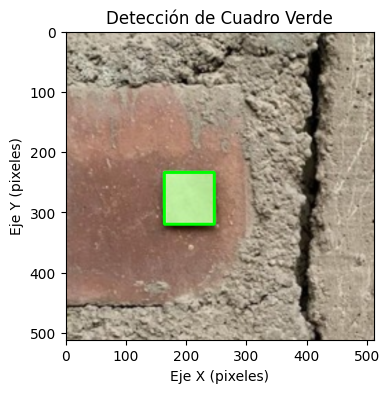

Ancho estimado de la escala verde: 83 píxeles
Escala: 4.15 píxeles por mm


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar la imagen original
# img = cv2.imread('/path/to/tu_imagen.jpg')

# Copia para procesar
img_for_processing = img.copy()

# Convertir a HSV para detección de color
hsv = cv2.cvtColor(img_for_processing, cv2.COLOR_BGR2HSV)

# Rango de color verde fluorescente
lower_green = np.array([35, 40, 40])
upper_green = np.array([85, 255, 255])

# Máscara
mask1 = cv2.inRange(hsv, lower_green, upper_green)

# Encontrar contornos
contornos, _ = cv2.findContours(mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujar sobre imagen original si se detecta un cuadrado
if contornos:
    contorno_mayor = max(contornos, key=cv2.contourArea)
    epsilon = 0.02 * cv2.arcLength(contorno_mayor, True)
    approx = cv2.approxPolyDP(contorno_mayor, epsilon, True)

    if len(approx) == 4:
        x, y, w, h = cv2.boundingRect(approx)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 3)
        print("Cuadrado verde detectado")
    else:
        print("No se detectó un cuadrado")
else:
    print("No se detectó ningún contorno")

# Convertir BGR a RGB para mostrar con matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Mostrar con título y ejes
plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.title("Detección de Cuadro Verde")
plt.xlabel("Eje X (pixeles)")
plt.ylabel("Eje Y (pixeles)")
plt.grid(False)
plt.show()

print(f"Ancho estimado de la escala verde: {w} píxeles")

longitud_real_mm = 20  # por ejemplo
escala_pixeles_por_mm = w / longitud_real_mm
print(f"Escala: {escala_pixeles_por_mm:.2f} píxeles por mm")


Cuadrado verde detectado


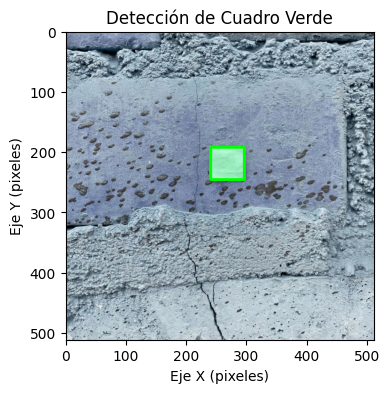

Ancho estimado de la escala verde: 55.0 píxeles
Escala: 2.750 píxeles por mm


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# img = cv2.imread('/path/to/tu_imagen.jpg')  # ya está cargada antes

# Copia para procesar
img_for_processing = img.copy()

# Convertir a HSV para detección de color
hsv = cv2.cvtColor(img_for_processing, cv2.COLOR_BGR2HSV)

# Rango de color verde fluorescente
lower_green = np.array([35, 40, 40])
upper_green = np.array([85, 255, 255])

# Máscara
mask1 = cv2.inRange(hsv, lower_green, upper_green)

# Encontrar contornos
contornos, _ = cv2.findContours(mask1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujo sobre una copia limpia
img_dibujo = img.copy()

# Dibujar sobre copia si se detecta un cuadrado
if contornos:
    contorno_mayor = max(contornos, key=cv2.contourArea)
    epsilon = 0.02 * cv2.arcLength(contorno_mayor, True)
    approx = cv2.approxPolyDP(contorno_mayor, epsilon, True)

    if len(approx) == 4:
        x, y, w, h = cv2.boundingRect(approx)
        cv2.rectangle(img_dibujo, (x, y), (x + w, y + h), (0, 255, 0), 3)
        print("Cuadrado verde detectado")
    else:
        print("No se detectó un cuadrado")
else:
    print("No se detectó ningún contorno")

# Convertir BGR a RGB para mostrar con matplotlib
img_rgb = cv2.cvtColor(img_dibujo, cv2.COLOR_BGR2RGB)

# Mostrar con título y ejes
plt.figure(figsize=(6, 4))
plt.imshow(img_rgb)
plt.title("Detección de Cuadro Verde")
plt.xlabel("Eje X (pixeles)")
plt.ylabel("Eje Y (pixeles)")
plt.grid(False)
plt.show()

# Escalado
print(f"Ancho estimado de la escala verde: {(w+h)/2} píxeles")
longitud_real_mm = 20
escala_pixeles_por_mm = ((w + h)/2) / longitud_real_mm
print(f"Escala: {escala_pixeles_por_mm:.3f} píxeles por mm")


# CLASIFICACION

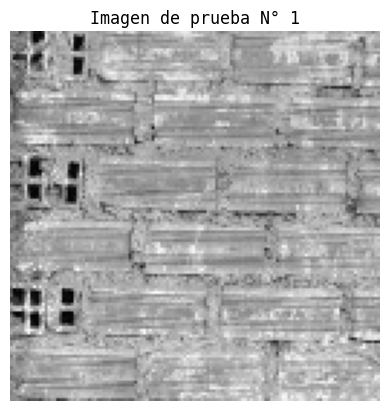

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Predicción: Pandereta (0) | Confianza: 0.00


In [ ]:
def predecir_imagen_gris_memoria(img, modelo):
    ALTO = 128
    ANCHO = 128

    # Convertir a escala de grises si la imagen tiene 3 canales
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Redimensionar imagen
    img_resized = cv2.resize(img, (ALTO, ANCHO))

    # Mostrar imagen
    plt.imshow(img_resized, cmap='gray')
    plt.axis('off')
    plt.title("Imagen de prueba N° 1")
    plt.show()

    # Normalizar y dar forma
    img_norm = img_resized.astype(np.float32) / 255.0
    img_norm = np.expand_dims(img_norm, axis=-1)  # (H, W, 1)
    img_norm = np.expand_dims(img_norm, axis=0)   # (1, H, W, 1)

    # Predecir
    pred = modelo.predict(img_norm)[0][0]

    # Mostrar resultado
    clase = "Macizo (1)" if pred >= 0.5 else "Pandereta (0)"
    print(f"Predicción: {clase} | Confianza: {pred:.2f}")


predecir_imagen_gris_memoria(img, modelo2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


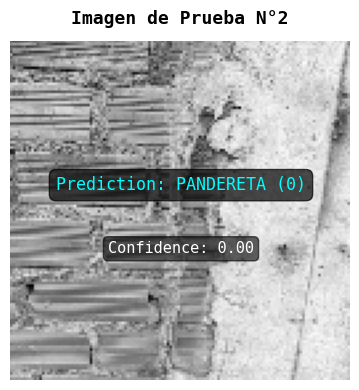

In [ ]:
def predecir_imagen_gris_memoria(img, modelo):
    import matplotlib.pyplot as plt
    from matplotlib import rcParams
    rcParams['font.family'] = 'monospace'  # Fuente tipo robótica

    ALTO = 128
    ANCHO = 128

    # Convertir a escala de grises si tiene 3 canales
    if len(img.shape) == 3 and img.shape[2] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Redimensionar imagen
    img_resized = cv2.resize(img, (ALTO, ANCHO))

    # Preparar para predicción
    img_norm = img_resized.astype(np.float32) / 255.0
    img_input = np.expand_dims(img_norm, axis=-1)
    img_input = np.expand_dims(img_input, axis=0)

    # Realizar predicción
    pred = modelo.predict(img_input)[0][0]
    clase = "PANDERETA (0)" if pred < 0.5 else "MACIZO (1)"
    linea1 = f"Prediction: {clase}"
    linea2 = f"Confidence: {pred:.2f}"

    # Oscurecer imagen para mejor contraste visual
    img_oscur = (img_resized * 0.5).astype(np.uint8)

    # Mostrar imagen con estilo profesional
    plt.figure(figsize=(4, 4))
    plt.imshow(img_oscur, cmap='gray')
    plt.axis('off')

    # Añadir título superior
    plt.title("Imagen de Prueba N°2", fontsize=13, fontweight='bold', color='black', pad=12)

    # Agregar texto centrado sobre la imagen
    plt.text(
        ALTO // 2, ALTO // 2 - 10, linea1,
        fontsize=12, color='cyan', ha='center', va='center',
        bbox=dict(facecolor='black', alpha=0.7, boxstyle='round,pad=0.4')
    )
    plt.text(
        ALTO // 2, ALTO // 2 + 14, linea2,
        fontsize=11, color='white', ha='center', va='center',
        bbox=dict(facecolor='black', alpha=0.6, boxstyle='round,pad=0.3')
    )

    plt.tight_layout()
    plt.show()



predecir_imagen_gris_memoria(img, modelo2)

# ANCHOS REALES VS PREDICHOS

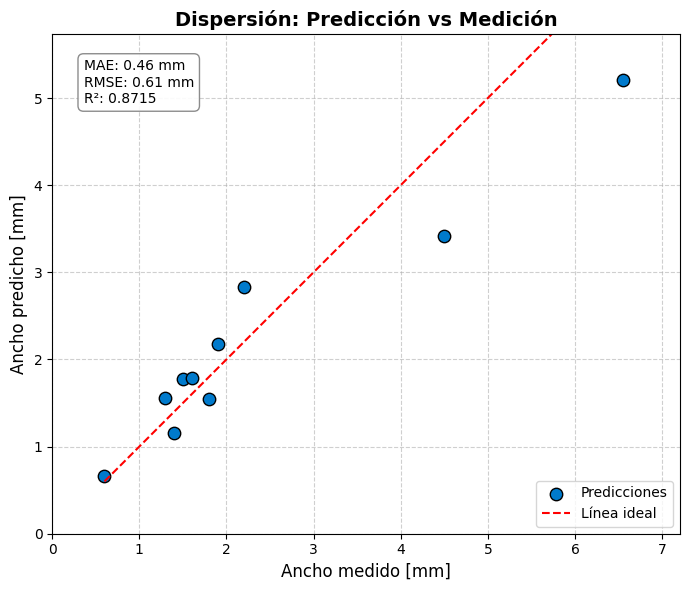

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Datos
anchos_medidos = np.array([1.5, 4.5, 1.9, 2.2, 1.8, 0.6, 6.55, 1.6, 1.4, 1.3])
anchos_predichos = np.array([1.78, 3.42, 2.18, 2.83, 1.55, 0.66, 5.21, 1.79, 1.16, 1.56])

# Métricas
mae = mean_absolute_error(anchos_medidos, anchos_predichos)
rmse = np.sqrt(mean_squared_error(anchos_medidos, anchos_predichos))
r2 = r2_score(anchos_medidos, anchos_predichos)

# Gráfico de dispersión
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(anchos_medidos, anchos_predichos, color='#007acc', s=80, edgecolors='black', label='Predicciones')
ax.plot([min(anchos_medidos), max(anchos_medidos)],
        [min(anchos_medidos), max(anchos_medidos)],
        'r--', label='Línea ideal')

# Estética
ax.set_xlabel("Ancho medido [mm]", fontsize=12)
ax.set_ylabel("Ancho predicho [mm]", fontsize=12)
ax.set_title("Dispersión: Predicción vs Medición", fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()

# Igualar ejes y márgenes
ax.set_xlim([0, max(anchos_medidos)*1.1])
ax.set_ylim([0, max(anchos_predichos)*1.1])
ax.set_aspect('equal')

# Métricas dentro del gráfico
metricas_texto = (
    f"MAE: {mae:.2f} mm\n"
    f"RMSE: {rmse:.2f} mm\n"
    f"R²: {r2:.4f}"
)
ax.text(0.05, 0.95, metricas_texto, transform=ax.transAxes,
        fontsize=10, va='top', ha='left',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9, edgecolor='gray'))

plt.tight_layout()
plt.show()




MAE (Error absoluto medio): 0.46 mm
Máximo error absoluto: 1.34 mm
Mediana del error absoluto: 0.27 mm
Desviación estándar del error: 0.40 mm


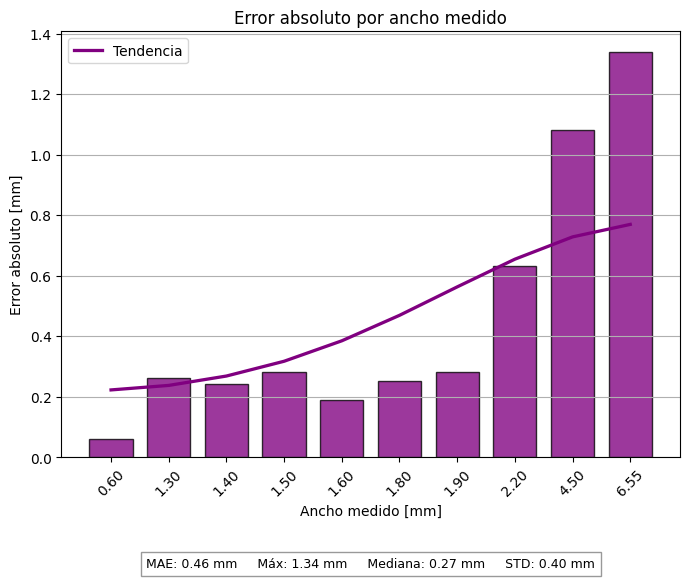

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Datos reales
anchos_medidos = np.array([1.5, 4.5, 1.9, 2.2, 1.8, 0.6, 6.55, 1.6, 1.4, 1.3])
anchos_predichos = np.array([1.78, 3.42, 2.18, 2.83, 1.55, 0.66, 5.21, 1.79, 1.16, 1.56])

# Cálculo del error absoluto
errores = np.abs(anchos_predichos - anchos_medidos)

# Ordenar según anchos_medidos
orden = np.argsort(anchos_medidos)
anchos_medidos_ordenados = anchos_medidos[orden]
errores_ordenados = errores[orden]

# Métricas
mae = np.mean(errores)
max_error = np.max(errores)
mediana = np.median(errores)
std_error = np.std(errores)

# Impresión por consola
print(f"MAE (Error absoluto medio): {mae:.2f} mm")
print(f"Máximo error absoluto: {max_error:.2f} mm")
print(f"Mediana del error absoluto: {mediana:.2f} mm")
print(f"Desviación estándar del error: {std_error:.2f} mm")

# Gráfico
fig, ax = plt.subplots(figsize=(7,6))
x = np.arange(len(anchos_medidos_ordenados))

# Barras púrpuras con contorno negro
bars = ax.bar(
    x, errores_ordenados,
    color='purple', alpha=0.78, width=0.75, edgecolor='black'
)

# Línea de tendencia suave (curva púrpura)
errores_suavizados = gaussian_filter1d(errores_ordenados, sigma=3.2)
ax.plot(
    x, errores_suavizados,
    color='purple', linewidth=2.35, linestyle='-', label='Tendencia'
)

# Ejes y etiquetas
ax.set_xticks(x)
ax.set_xticklabels([f"{val:.2f}" for val in anchos_medidos_ordenados], rotation=45)
ax.set_xlabel("Ancho medido [mm]")
ax.set_ylabel("Error absoluto [mm]")
ax.set_title("Error absoluto por ancho medido")
ax.grid(axis='y')  # Solo cuadrículas horizontales
ax.legend()

# Resumen de métricas dentro del gráfico
summary_text = (
    f"MAE: {mae:.2f} mm     Máx: {max_error:.2f} mm     "
    f"Mediana: {mediana:.2f} mm     STD: {std_error:.2f} mm"
)
ax.text(
    0.5, -0.25, summary_text,
    ha='center', va='center', fontsize=9,
    transform=ax.transAxes,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.tight_layout()
plt.show()



MAE (Error porcentual medio): 17.94 %
Máximo error porcentual: 28.64 %
Mediana del error porcentual: 17.90 %
Desviación estándar del error: 5.38 %


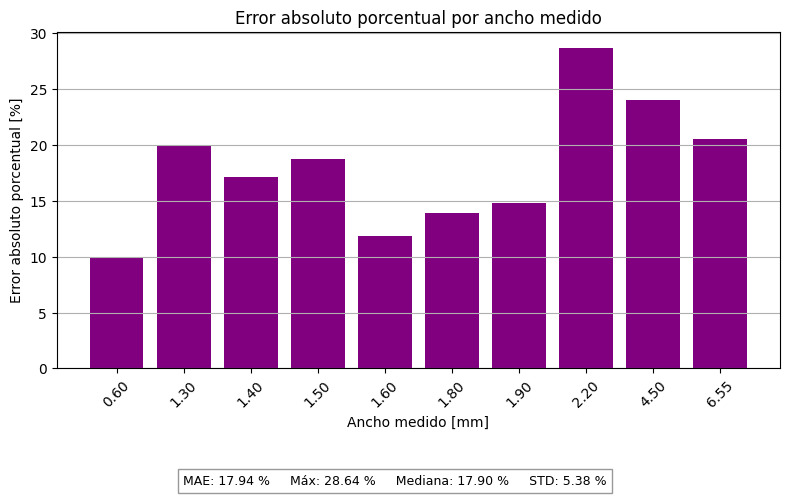

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Datos reales
anchos_medidos = np.array([1.5, 4.5, 1.9, 2.2, 1.8, 0.6, 6.55, 1.6, 1.4, 1.3])
anchos_predichos = np.array([1.78, 3.42, 2.18, 2.83, 1.55, 0.66, 5.21, 1.79, 1.16, 1.56])

# Cálculo del error absoluto porcentual [%]
errores = 100 * np.abs(anchos_predichos - anchos_medidos) / anchos_medidos

# Ordenar según anchos_medidos
orden = np.argsort(anchos_medidos)
anchos_medidos_ordenados = anchos_medidos[orden]
errores_ordenados = errores[orden]

# Cálculo de métricas
mae = np.mean(errores)
max_error = np.max(errores)
mediana = np.median(errores)
std_error = np.std(errores)

# Impresión de métricas
print(f"MAE (Error porcentual medio): {mae:.2f} %")
print(f"Máximo error porcentual: {max_error:.2f} %")
print(f"Mediana del error porcentual: {mediana:.2f} %")
print(f"Desviación estándar del error: {std_error:.2f} %")

# Gráfico
fig, ax = plt.subplots(figsize=(8, 4.5))
x = np.arange(len(anchos_medidos_ordenados))

# Barras
ax.bar(x, errores_ordenados, color='purple')
ax.set_xticks(x)
ax.set_xticklabels([f"{val:.2f}" for val in anchos_medidos_ordenados], rotation=45)
ax.set_xlabel("Ancho medido [mm]")
ax.set_ylabel("Error absoluto porcentual [%]")
ax.set_title("Error absoluto porcentual por ancho medido")
ax.grid(axis='y')

# Texto con métricas, centrado abajo
summary_text = (
    f"MAE: {mae:.2f} %     Máx: {max_error:.2f} %     "
    f"Mediana: {mediana:.2f} %     STD: {std_error:.2f} %"
)
fig.text(
    0.5, -0.08, summary_text,
    ha='center', va='center', fontsize=9,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray')
)

plt.tight_layout()
plt.show()



MAPE: 17.94%
Q1: 14.10%, Mediana (Q2): 17.90%, Q3: 20.34%
Min (sin outliers): 10.00%, Max (sin outliers): 28.64%


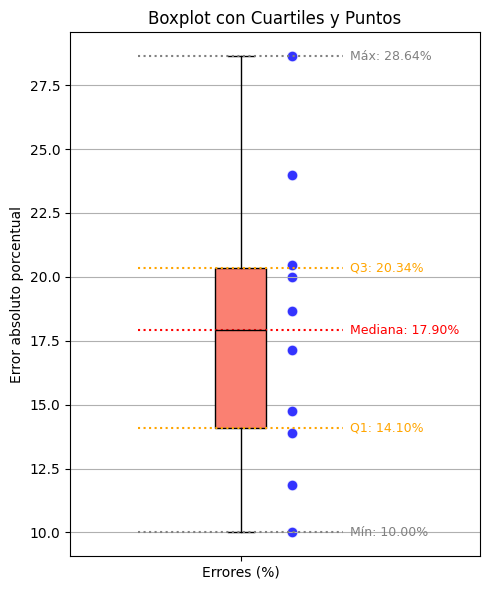

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Datos
anchos_medidos = np.array([1.5, 4.5, 1.9, 2.2, 1.8, 0.6, 6.55, 1.6, 1.4, 1.3])
anchos_predichos = np.array([1.78, 3.42, 2.18, 2.83, 1.55, 0.66, 5.21, 1.79, 1.16, 1.56])

# Errores absolutos porcentuales
errores_pct = np.abs((anchos_predichos - anchos_medidos) / anchos_medidos) * 100
mape = np.mean(errores_pct)

# Calcular estadísticas
q1 = np.percentile(errores_pct, 25)
q2 = np.median(errores_pct)
q3 = np.percentile(errores_pct, 75)
iqr = q3 - q1
min_val = np.min(errores_pct[errores_pct >= (q1 - 1.5 * iqr)])
max_val = np.max(errores_pct[errores_pct <= (q3 + 1.5 * iqr)])

# Mostrar MAPE y estadísticas
print(f"MAPE: {mape:.2f}%")
print(f"Q1: {q1:.2f}%, Mediana (Q2): {q2:.2f}%, Q3: {q3:.2f}%")
print(f"Min (sin outliers): {min_val:.2f}%, Max (sin outliers): {max_val:.2f}%")

# Gráfico
plt.figure(figsize=(5,6))

# Boxplot
plt.boxplot(errores_pct, vert=True, patch_artist=True,
            boxprops=dict(facecolor='salmon', edgecolor='black'),
            medianprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(marker='o', color='gray', alpha=0.5))

# Puntos individuales al lado derecho
x_offset = 1.15
plt.scatter(np.full_like(errores_pct, x_offset), errores_pct,
            color='blue', alpha=0.8, s=60, edgecolors='white', linewidths=0.8)

# Dibujar y etiquetar líneas de cuartiles y extremos
lineas = [
    ("Mín", min_val, 'gray'),
    ("Q1", q1, 'orange'),
    ("Mediana", q2, 'red'),
    ("Q3", q3, 'orange'),
    ("Máx", max_val, 'gray')
]

for nombre, valor, color in lineas:
    plt.hlines(valor, xmin=0.7, xmax=1.3, colors=color, linestyles='dotted', linewidth=1.5)
    plt.text(1.32, valor, f"{nombre}: {valor:.2f}%", va='center', ha='left', fontsize=9, color=color)

# Estética
plt.xticks([1], ['Errores (%)'])
plt.ylabel("Error absoluto porcentual")
plt.title("Boxplot con Cuartiles y Puntos")
plt.grid(True, axis='y')
plt.xlim(0.5, 1.7)
plt.tight_layout()
plt.show()


#TIEMPO DE INFERENCIA

In [ ]:
modelo = load_model('/content/modelo3_b2.h5', custom_objects={'RepeatChannels': RepeatChannels, 'loss': Weighted_Cross_Entropy(10.0)})

In [ ]:
# Directorio del dataset
TEST_PATH = '/content/drive/MyDrive/TESIS/Datos3/train/'

# Imágenes y máscaras de entrenamiento -> Listado y ordenado
test_images_ids = sorted(os.listdir(TEST_PATH + 'images/'))
test_masks_ids = sorted(os.listdir(TEST_PATH + 'masks/'))

# Arreglos vacíos para imágenes y máscaras
X_test = np.zeros((len(test_images_ids), 512, 512, 3), dtype=np.uint8)
Y_test = np.zeros((len(test_masks_ids), 512, 512, 1), dtype=np.bool)

# Redimensión de imágenes
for n, id in tqdm(enumerate(test_images_ids), total=len(test_images_ids)):
    path = TEST_PATH + 'images/' + id
    img = imread(path)[:,:,:3]
    if img.shape[:2] != (512, 512):
        img = resize(img, (512, 512, 3), preserve_range=True, mode='constant')
    X_test[n] = img

for m, id in tqdm(enumerate(test_masks_ids), total=len(test_masks_ids)):
    path = TEST_PATH + 'masks/' + id
    mask = imread(path)
        # Asegurar que tenga un canal (grises)
    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)
    elif mask.ndim == 3 and mask.shape[2] == 3:
        # Si es RGB, convertir a escala de grises
        mask = np.expand_dims(rgb2gray(mask), axis=-1)

    # Redimensionar solo si es necesario
    if mask.shape != (512, 512, 1):
        mask = resize(mask, (512, 512, 1), preserve_range=True, mode='constant', anti_aliasing=False)

    Y_test[m] = mask

  6%|▌         | 5/90 [00:02<00:35,  2.38it/s]


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from skimage.morphology import skeletonize
from tensorflow.keras.models import load_model
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm
from skimage.color import rgb2gray

# ========== CARGA DEL MODELO ==========
modelo = load_model('/content/modelo3_b2.h5', custom_objects={'RepeatChannels': RepeatChannels, 'loss': Weighted_Cross_Entropy(10.0)})

# ========== CARGA DE DATOS ==========
TEST_PATH = '/content/drive/MyDrive/TESIS/Datos3/train/'
test_images_ids = sorted(os.listdir(TEST_PATH + 'images/'))
X_test = np.zeros((len(test_images_ids), 512, 512, 3), dtype=np.uint8)

for n, id in tqdm(enumerate(test_images_ids), total=len(test_images_ids)):
    path = TEST_PATH + 'images/' + id
    img = imread(path)[:,:,:3]
    if img.shape[:2] != (512, 512):
        img = resize(img, (512, 512, 3), preserve_range=True, mode='constant')
    X_test[n] = img

# ========== PREDICCIÓN ==========
predicciones = modelo.predict(X_test, verbose=1)
umbral = 0.5
mascaras_binarias = (predicciones > umbral).astype(np.uint8)


100%|██████████| 90/90 [01:21<00:00,  1.10it/s]


3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 8s/step


In [ ]:
import numpy as np
import cv2
import time
from skimage.morphology import skeletonize
from tqdm import tqdm

# Arreglo para guardar los tiempos de cada imagen
tiempos_esqueletizacion = []

for i in tqdm(range(len(mascaras_binarias))):
    binary_mask = mascaras_binarias[i, :, :, 0]

    inicio = time.time()

    # Asegurar binaria
    binary = (binary_mask > 0).astype(np.uint8)

    # Esqueletización
    skeleton = skeletonize(binary).astype(np.uint8)

    # Transformada de distancia euclidiana
    dist_transform = cv2.distanceTransform(binary, distanceType=cv2.DIST_L2, maskSize=5)

    # Mapa de anchos = esqueleto * distancia * 2
    crack_width_map = dist_transform * skeleton * 2

    # Ancho máximo
    max_width = crack_width_map.max()

    fin = time.time()

    # Tiempo de procesamiento para esta imagen
    duracion = fin - inicio
    tiempos_esqueletizacion.append(duracion)

    print(f"Imagen {i+1}: Tiempo = {duracion:.4f} s | Ancho máximo = {max_width:.2f} px")

# Convertir a array si lo deseas
tiempos_esqueletizacion = np.array(tiempos_esqueletizacion)



 39%|███▉      | 35/90 [00:00<00:00, 172.73it/s]

Imagen 1: Tiempo = 0.0287 s | Ancho máximo = 4.00 px
Imagen 2: Tiempo = 0.0047 s | Ancho máximo = 6.39 px
Imagen 3: Tiempo = 0.0045 s | Ancho máximo = 8.00 px
Imagen 4: Tiempo = 0.0038 s | Ancho máximo = 2.80 px
Imagen 5: Tiempo = 0.0084 s | Ancho máximo = 16.00 px
Imagen 6: Tiempo = 0.0037 s | Ancho máximo = 4.39 px
Imagen 7: Tiempo = 0.0045 s | Ancho máximo = 4.00 px
Imagen 8: Tiempo = 0.0037 s | Ancho máximo = 4.39 px
Imagen 9: Tiempo = 0.0045 s | Ancho máximo = 6.00 px
Imagen 10: Tiempo = 0.0076 s | Ancho máximo = 17.18 px
Imagen 11: Tiempo = 0.0045 s | Ancho máximo = 6.00 px
Imagen 12: Tiempo = 0.0041 s | Ancho máximo = 4.39 px
Imagen 13: Tiempo = 0.0038 s | Ancho máximo = 4.00 px
Imagen 14: Tiempo = 0.0045 s | Ancho máximo = 4.00 px
Imagen 15: Tiempo = 0.0142 s | Ancho máximo = 39.20 px
Imagen 16: Tiempo = 0.0039 s | Ancho máximo = 4.00 px
Imagen 17: Tiempo = 0.0062 s | Ancho máximo = 10.39 px
Imagen 18: Tiempo = 0.0060 s | Ancho máximo = 12.79 px
Imagen 19: Tiempo = 0.0031 s | A

 61%|██████    | 55/90 [00:00<00:00, 183.82it/s]

Imagen 40: Tiempo = 0.0039 s | Ancho máximo = 4.00 px
Imagen 41: Tiempo = 0.0048 s | Ancho máximo = 6.00 px
Imagen 42: Tiempo = 0.0054 s | Ancho máximo = 10.39 px
Imagen 43: Tiempo = 0.0054 s | Ancho máximo = 8.40 px
Imagen 44: Tiempo = 0.0037 s | Ancho máximo = 2.80 px
Imagen 45: Tiempo = 0.0055 s | Ancho máximo = 8.79 px
Imagen 46: Tiempo = 0.0062 s | Ancho máximo = 10.39 px
Imagen 47: Tiempo = 0.0044 s | Ancho máximo = 4.39 px
Imagen 48: Tiempo = 0.0062 s | Ancho máximo = 10.79 px
Imagen 49: Tiempo = 0.0046 s | Ancho máximo = 8.40 px
Imagen 50: Tiempo = 0.0053 s | Ancho máximo = 6.39 px
Imagen 51: Tiempo = 0.0062 s | Ancho máximo = 12.00 px
Imagen 52: Tiempo = 0.0037 s | Ancho máximo = 4.00 px
Imagen 53: Tiempo = 0.0046 s | Ancho máximo = 6.00 px
Imagen 54: Tiempo = 0.0077 s | Ancho máximo = 15.18 px
Imagen 55: Tiempo = 0.0039 s | Ancho máximo = 6.39 px
Imagen 56: Tiempo = 0.0064 s | Ancho máximo = 12.79 px
Imagen 57: Tiempo = 0.0038 s | Ancho máximo = 4.39 px
Imagen 58: Tiempo = 0.

100%|██████████| 90/90 [00:00<00:00, 160.45it/s]

Imagen 73: Tiempo = 0.0058 s | Ancho máximo = 8.79 px
Imagen 74: Tiempo = 0.0047 s | Ancho máximo = 7.19 px
Imagen 75: Tiempo = 0.0063 s | Ancho máximo = 10.39 px
Imagen 76: Tiempo = 0.0038 s | Ancho máximo = 4.00 px
Imagen 77: Tiempo = 0.0052 s | Ancho máximo = 6.00 px
Imagen 78: Tiempo = 0.0046 s | Ancho máximo = 5.60 px
Imagen 79: Tiempo = 0.0037 s | Ancho máximo = 6.00 px
Imagen 80: Tiempo = 0.0054 s | Ancho máximo = 10.00 px
Imagen 81: Tiempo = 0.0061 s | Ancho máximo = 14.00 px
Imagen 82: Tiempo = 0.0070 s | Ancho máximo = 13.18 px
Imagen 83: Tiempo = 0.0142 s | Ancho máximo = 39.59 px
Imagen 84: Tiempo = 0.0054 s | Ancho máximo = 10.79 px
Imagen 85: Tiempo = 0.0349 s | Ancho máximo = 91.48 px
Imagen 86: Tiempo = 0.0061 s | Ancho máximo = 12.79 px
Imagen 87: Tiempo = 0.0077 s | Ancho máximo = 16.79 px
Imagen 88: Tiempo = 0.0038 s | Ancho máximo = 2.80 px
Imagen 89: Tiempo = 0.0036 s | Ancho máximo = 2.00 px
Imagen 90: Tiempo = 0.0030 s | Ancho máximo = 2.00 px
